We are going to use the RGB construction from [CEOS tutorial](http://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf) to visualize our products. We simply construct images with:

    Red = HH
    Green = HV
    Blue = VV
    
For a standard RGB image.

In [1]:
import rasterio
import numpy
from rabasar import scale_img
from itertools import starmap
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Read Config File

In [2]:
config_dict = json.load(open('config.json', 'r'))
config_dict

{'sensor': 'uavsar', 'site': 'waxlake', 'regularizer': 'tv'}

In [3]:
SENSOR = config_dict['sensor']
SITE = config_dict['site']
REGULARIZER = config_dict['regularizer']

In [4]:
WEIGHT = 1.

# Data Paths

In [5]:
data_dir_path_name = f'{SENSOR}_{SITE}/data_reprojected'
if REGULARIZER != 'tv':
    data_dir_path_name += '_tv'
DATA_DIR = Path(data_dir_path_name)
DATA_DIR.exists()

True

In [6]:
RATIO_DIR =Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/rabasar_{REGULARIZER}')
RATIO_DIR.exists()

True

In [7]:
hh_paths_rabasar = sorted(list(RATIO_DIR.glob('final*/hh/*hh*.tif')))
hv_paths_rabasar = sorted(list(RATIO_DIR.glob('final*/hv/*hv*.tif')))
vv_paths_rabasar = sorted(list(RATIO_DIR.glob('final*/vv/*vv*.tif')))

hh_paths_rabasar

[PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/hh/uavsar_waxlake_hh_RTC_20190620_tv_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/hh/uavsar_waxlake_hh_RTC_20190701_tv_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/hh/uavsar_waxlake_hh_RTC_20190716_tv_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/hh/uavsar_waxlake_hh_RTC_20190725_tv_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/hh/uavsar_waxlake_hh_RTC_20190812_tv_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/hh/uavsar_waxlake_hh_RTC_20190923_tv_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_tv/final_weight_1.00/hh/uavsar_waxlake_hh_RTC_20190930_tv_weight_1.00.tif')]

In [8]:
ta_image_dir_name = f'out/{SENSOR}_{SITE}_{REGULARIZER}/temporally_averaged_image_{REGULARIZER}/weight_{WEIGHT:1.2f}'
TEMPORALLY_AVERAGED_IMAGE_DIR_TV = Path(ta_image_dir_name)
TEMPORALLY_AVERAGED_IMAGE_DIR_TV.exists()

True

In [9]:
ta_tv_paths = sorted(list(TEMPORALLY_AVERAGED_IMAGE_DIR_TV.glob('*.tif')))
ta_tv_paths

[PosixPath('out/uavsar_waxlake_tv/temporally_averaged_image_tv/weight_1.00/waxlake_uavsar_temporally_average_hh_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/temporally_averaged_image_tv/weight_1.00/waxlake_uavsar_temporally_average_hv_tv_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/temporally_averaged_image_tv/weight_1.00/waxlake_uavsar_temporally_average_vv_tv_1.00.tif')]

# Opening data

In [10]:
def open_one(path):
    with rasterio.open(path) as ds:
        img = ds.read(1)
    return img

ta_tv_reference_images = list(map(open_one, ta_tv_paths))

In [11]:
hv_ts = list(map(open_one, tqdm(hv_paths_rabasar)))
hh_ts = list(map(open_one, tqdm(hh_paths_rabasar)))
vv_ts = list(map(open_one, tqdm(vv_paths_rabasar)))

100%|██████████| 7/7 [00:01<00:00,  5.05it/s]


In [12]:
with rasterio.open(ta_tv_paths[0]) as ds:
    profile = ds.profile

# Subset and Display

In [13]:
if SITE == 'waxlake' and SENSOR == 'uavsar' and REGULARIZER == 'tv':
    sy = np.s_[-2000:-1000]
    sx = np.s_[-3000:-2000]
else:
    raise NotImplementedError

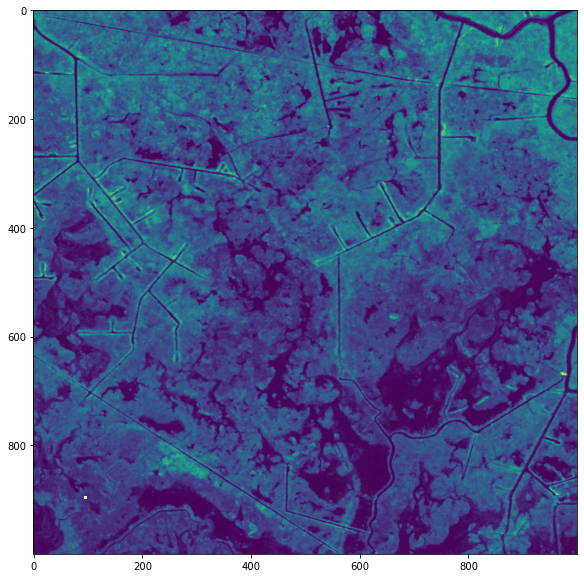

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(ta_tv_reference_images[0][sy, sx])

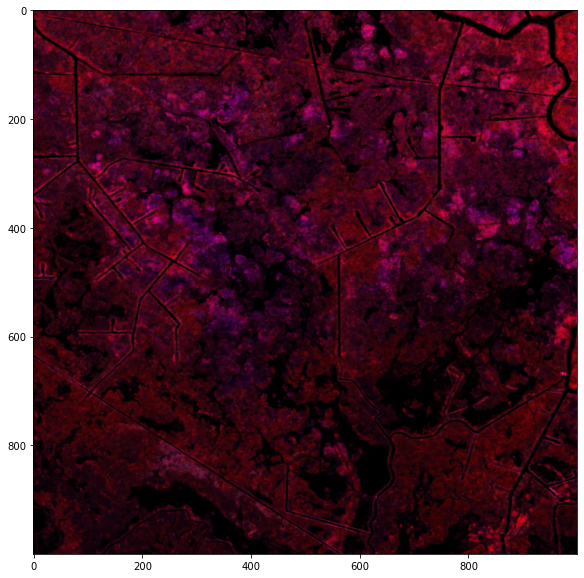

In [15]:
plt.figure(figsize=(10, 10))
IND = 1
rgb = np.stack([hh_ts[IND], 
                hv_ts[IND], 
                vv_ts[IND]],
               axis=2)
rgb_c = scale_img(rgb[sy, sx, :])
plt.imshow(rgb_c)

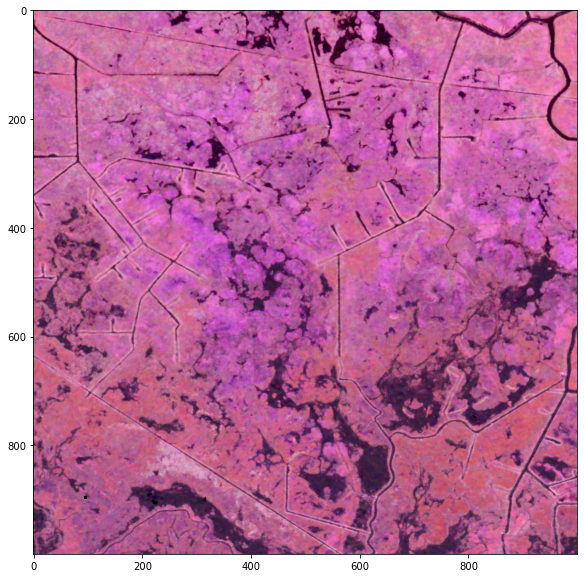

In [16]:
plt.figure(figsize=(10, 10))
IND = 1
mask = np.isnan(hh_ts[0])

f = lambda x: 10 * np.log10(x, where=~mask, out=np.ones(mask.shape)*np.nan)
rgb_db = np.stack([f(hh_ts[IND]), 
                   f(hv_ts[IND]), 
                   f(vv_ts[IND])
                  ],
                   axis=2)
rgb_db_c = scale_img(rgb_db[sy, sx, :])
plt.imshow(rgb_db_c)

# Obtain RGBs

## For time series

In [17]:
hh_names = list(map(lambda x: x.name, hh_paths_rabasar))
hv_names = list(map(lambda x: x.name, hv_paths_rabasar))
vv_names = list(map(lambda x: x.name, vv_paths_rabasar))

n = len(hv_names)

In [18]:
def make_rgb_db(hh, hv, vv):
    stack = [10 * np.log10(hh),
             10 * np.log10(hv),
             10 * np.log10(vv)]
    stack = np.stack(stack, axis=2)
    stack = np.clip(stack, -30, 0)
    return scale_img(stack)


def make_rgb(hh, hv, vv):
    stack = [(hh),
             (hv),
             (vv)]
    stack = np.stack(stack, axis=2)
    return scale_img(stack)

ind = 0
rgb = make_rgb(hh_ts[ind], hv_ts[ind], vv_ts[ind])
rgb_db = make_rgb_db(hh_ts[ind], hv_ts[ind], vv_ts[ind])


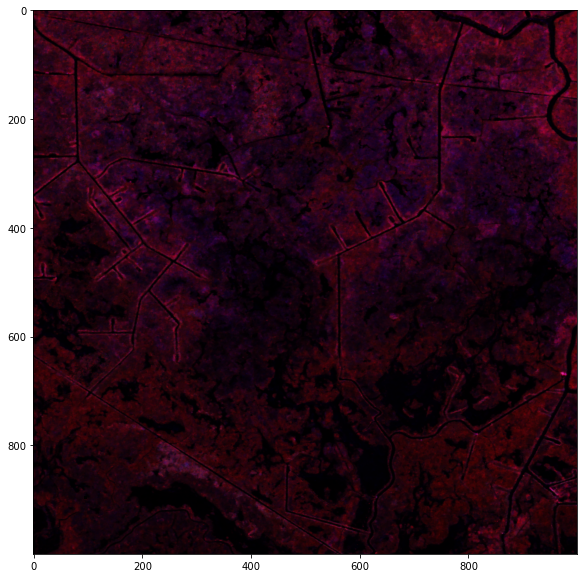

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb[sy, sx, :])

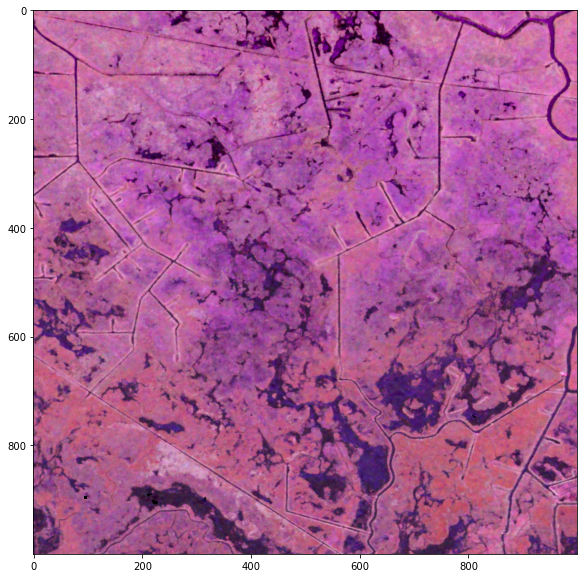

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb_db[sy, sx, :])

In [21]:
rgb_dir = Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/rabasar_rgb_{REGULARIZER}_weight_{WEIGHT:1.2f}')
rgb_dir.mkdir(exist_ok=True, parents=True)

In [22]:
rgb_db_dir = Path(f'out/{SENSOR}_{SITE}_{REGULARIZER}/rabasar_rgb_db_{REGULARIZER}_weight_{WEIGHT:1.2f}')
rgb_db_dir.mkdir(exist_ok=True, parents=True)

In [23]:
def make_and_write_rgb(hh, hv, vv, file_name, scale):
    if scale == 'db':
        dest_dir = rgb_db_dir
        rgb_func = make_rgb_db
    elif scale == 'linear':
        dest_dir = rgb_dir
        rgb_func = make_rgb
    else:
        raise ValueError('Unspecified scale; must be linear or db')
        
    rgb = rgb_func(hh, hv, vv)
    p_rgb = profile.copy()
    p_rgb['count'] = 3
    
    file_name = (file_name[:11] +
                 'rgb'+
                 file_name[13:-4]
                 + f'_weight_{WEIGHT:1.2f}.tif')
    
    dest_path = dest_dir/file_name
    with rasterio.open(dest_path, 'w', **p_rgb) as ds:
        ds.write(rgb.transpose([2, 0, 1]).astype(np.float32))
    return dest_path

In [24]:
list(starmap(make_and_write_rgb, zip(tqdm(hh_ts), hv_ts, vv_ts, hh_names, ['linear'] * n)))

100%|██████████| 7/7 [00:15<00:00,  2.22s/it]


[PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190620_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190701_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190716_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190725_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190812_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190923_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190930_tv_weight_1.00_weight_1.00.tif')]

In [25]:
list(starmap(make_and_write_rgb, zip(tqdm(hh_ts), hv_ts, vv_ts, hh_names, ['db'] * n)))

100%|██████████| 7/7 [00:19<00:00,  2.84s/it]


[PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_db_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190620_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_db_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190701_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_db_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190716_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_db_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190725_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_db_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190812_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_db_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190923_tv_weight_1.00_weight_1.00.tif'),
 PosixPath('out/uavsar_waxlake_tv/rabasar_rgb_db_tv_weight_1.00/uavsar_waxlrgbe_hh_RTC_20190930_tv_weight_1.00_weight_1.00.tif')]

# RGB Reference Image

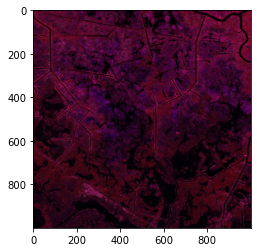

In [26]:
ta_reference_rgb = make_rgb(*ta_tv_reference_images)
plt.imshow(ta_reference_rgb[sy, sx, :])

In [27]:
dest_path = f'out/{SENSOR}_{SITE}_{REGULARIZER}/temporally_averaged_rgb_{REGULARIZER}_weight_{WEIGHT:1.2f}.tif'
p = profile.copy()
p['count'] = 3
with rasterio.open(dest_path, 'w', **p) as ds:
    ds.write(rgb.transpose([2, 0, 1]))